In [2]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [3]:
import os, sys
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# disabling log messages from TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# creating an end of run alarm
from IPython.display import Audio
sound_file = '/Users/dsbox/Documents/Flatiron/phase_5/WAILERLP.wav'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_DatabaseF as dbf
from src import class_Harness as h

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer, confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

# import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

from keras import layers, models, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

time: 19.8 s


## Creating The Database

In [11]:
# creating database & database class instance
database_name = 'outcomes.db'
db = dbf.Database(database_name)

time: 6.48 ms


**Run The Cell Below Once And Then Comment Out**

In [12]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 627 µs


### Database ERD

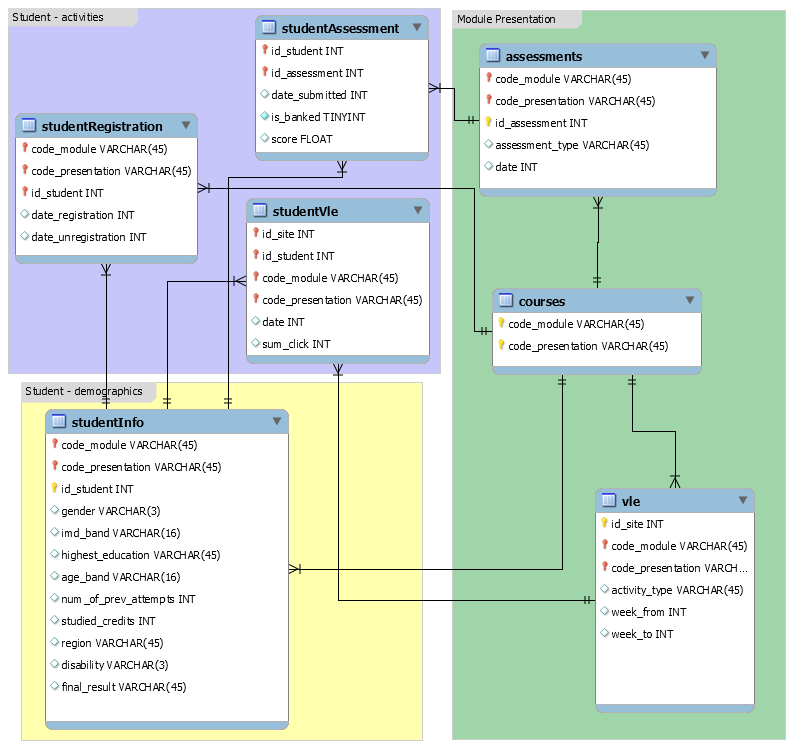

time: 2.74 ms


In [13]:
db.erd

## Preprocessing and Harness Objects

In [14]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))
sm = SMOTE(random_state=2021)

time: 1.3 ms


In [15]:
# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 3.09 ms


# STUDENTINFO Data

In [16]:
db.table_info('STUDENTINFO')

[(0, 'code_module', 'TEXT', 0, None, 0),
 (1, 'code_presentation', 'TEXT', 0, None, 0),
 (2, 'id_student', 'TEXT', 0, None, 0),
 (3, 'gender', 'TEXT', 0, None, 0),
 (4, 'region', 'TEXT', 0, None, 0),
 (5, 'highest_education', 'TEXT', 0, None, 0),
 (6, 'imd_band', 'TEXT', 0, None, 0),
 (7, 'age_band', 'TEXT', 0, None, 0),
 (8, 'num_of_prev_attempts', 'TEXT', 0, None, 0),
 (9, 'studied_credits', 'TEXT', 0, None, 0),
 (10, 'disability', 'TEXT', 0, None, 0),
 (11, 'final_result', 'TEXT', 0, None, 0)]

time: 3.65 ms


## Creating STUDENTINFO Data Frame

In [17]:
df = db.student_info()

time: 185 ms


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  object
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  object
 9   studied_credits       32593 non-null  object
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
 12  row_id                32593 non-null  object
 13  target                32593 non-null  int64 
dtypes: int64(1), object(13)
memory usage: 3.5+ MB
time: 29.9 ms


In [19]:
df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,row_id,target
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,AAA2013J11391,0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,AAA2013J28400,0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,AAA2013J30268,1
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,AAA2013J31604,0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,AAA2013J32885,0


time: 36.9 ms


In [20]:
df = db.sql_fixes(df)

time: 74.4 ms


In [21]:
drops = ['row_id', 'code_module', 'code_presentation',
         'id_student', 'final_result', 'studied_credits']

time: 848 µs


In [22]:
df = db.pipe_cleaner(df, drops)

time: 66.9 ms


In [23]:
df.target.value_counts(normalize=True)

1    0.531724
0    0.468276
Name: target, dtype: float64

time: 4.08 ms


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31144 entries, 1 to 32592
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                31144 non-null  int64   
 1   gender                31144 non-null  object  
 2   region                31144 non-null  object  
 3   highest_education     31144 non-null  object  
 4   imd_band              31144 non-null  object  
 5   age_band              31144 non-null  object  
 6   num_of_prev_attempts  31144 non-null  object  
 7   disability            31144 non-null  object  
 8   course_load           31144 non-null  category
dtypes: category(1), int64(1), object(7)
memory usage: 2.2+ MB
time: 17.7 ms


## Creating Holdout Data

In [25]:
# splitting data & target
X, y = f.X_y(df)

time: 3.39 ms


In [26]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 14.8 ms


## Creating Training Data

In [27]:
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 12.2 ms


## Baseline Model: Dummy Classifier

In [28]:
dummy = DummyClassifier(strategy='most_frequent')

time: 820 µs


In [29]:
baseline = make_pipeline(preprocessing_ohe, dummy)

time: 822 µs


### Fitting Model

In [30]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>)])),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))])

time: 69.6 ms


### Saving Model

In [31]:
# f.pickle_model(baseline, 'baseline')

time: 727 µs


### Cross Val Scores

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    modeling.report(baseline, X_train, y_train, ' Baseline', 'Baseline DummyCFL')

 Baseline has an average Accuracy of 0.5317387933630273
 Baseline has an average F1 of 0.6942943448460349
 Baseline has an average Recall of 1.0
 Baseline has an average Precision of 0.5317387933630273
time: 364 ms


### Test Data Confusion Matrix

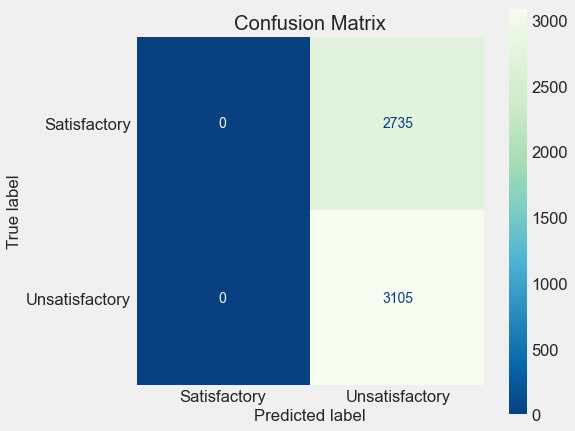

,Accuracy,F1,Recall,Precision
0,0.531678,0.694243,1.0,0.531678


time: 428 ms


In [33]:
%%capture --no-display
f.confusion_report(baseline, X_test, y_test, 'baseline')

## First Simple Model: Naive Bayes Classifier

In [34]:
mnb = MultinomialNB()

time: 895 µs


In [35]:
fsm = make_pipeline(preprocessing_ohe, mnb)

time: 978 µs


### Fitting Model

In [36]:
fsm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>)])),
                ('multinomialnb', MultinomialNB())])

time: 61.6 ms


### Saving Model

In [37]:
# f.pickle_model(fsm, 'fsm')

time: 701 µs


### Cross Val Scores

In [38]:
# checking cross val scores
modeling.report(fsm, X_train, y_train, ' fsm', 'FSM Naive Bayes')

 fsm has an average Accuracy of 0.5916768014891345
 fsm has an average F1 of 0.6322452250401034
 fsm has an average Recall of 0.6601180891035965
 fsm has an average Precision of 0.6066617559420104


[0.5916768014891345,
 0.6322452250401034,
 0.6601180891035965,
 0.6066617559420104]

time: 365 ms


### Test Data Confusion Matrix

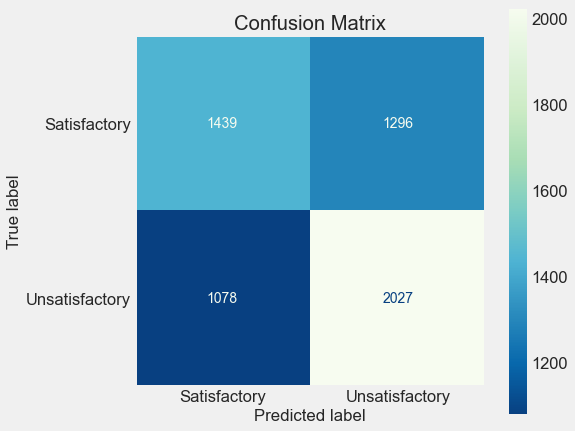

,Accuracy,F1,Recall,Precision
0,0.593493,0.630678,0.652818,0.609991


time: 390 ms


In [39]:
f.confusion_report(fsm, X_test, y_test, 'fsm')

## KNeighborsClassifier

In [40]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 849 µs


In [41]:
knn = make_pipeline(preprocessing_ohe, KNN)

time: 980 µs


### Fitting Model

In [42]:
knn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 61.3 ms


In [43]:
# f.pickle_model(knn, 'knn')

time: 749 µs


### Cross Val Scores

In [44]:
# checking cross val scores
modeling.report(knn, X_train, y_train, 'knn', 'KNN')

knn has an average Accuracy of 0.5476089151242836
knn has an average F1 of 0.5820768181323872
knn has an average Recall of 0.5925925925925926
knn has an average Precision of 0.5719650224760784


[0.5476089151242836,
 0.5820768181323872,
 0.5925925925925926,
 0.5719650224760784]

time: 12.3 s


### Test Data Confusion Matrix

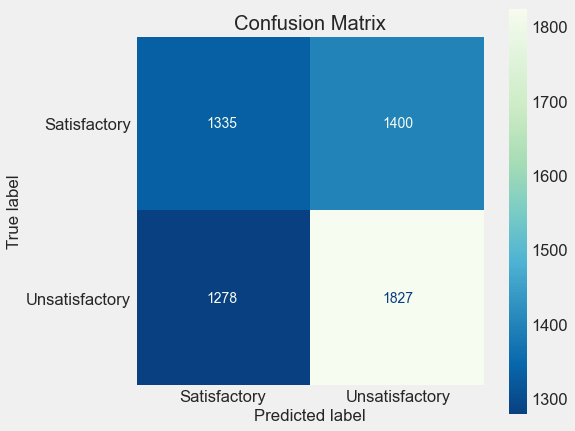

,Accuracy,F1,Recall,Precision
0,0.541438,0.577069,0.588406,0.566161


time: 27.5 s


In [45]:
f.confusion_report(knn, X_test, y_test)

## Logistic Regression Classifier

In [46]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=0)

time: 1.17 ms


In [47]:
logreg = make_pipeline(preprocessing_ohe, LR)

time: 1.14 ms


### Fitting Model

In [48]:
logreg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 4.13 s


In [49]:
# f.pickle_model(logreg, 'logreg')

time: 934 µs


### Cross Val Scores

In [50]:
# checking cross val scores
modeling.report(logreg, X_train, y_train, 'logreg', 'Logistic Regression')

logreg has an average Accuracy of 0.5959580144611859
logreg has an average F1 of 0.6378999205930793
logreg has an average Recall of 0.6694578636607622
logreg has an average Precision of 0.6092986437167408


[0.5959580144611859,
 0.6378999205930793,
 0.6694578636607622,
 0.6092986437167408]

time: 4.19 s


### Test Data Confusion Matrix

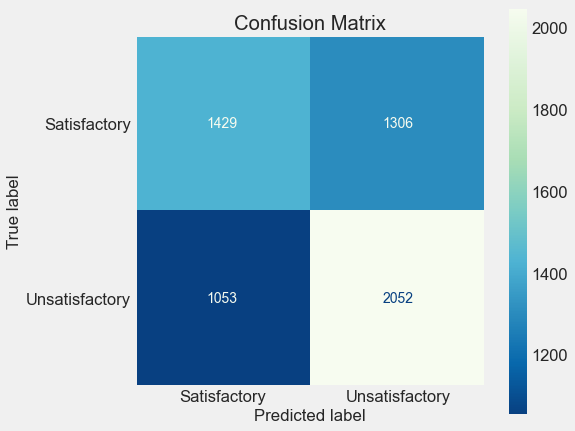

,Accuracy,F1,Recall,Precision
0,0.596062,0.634999,0.66087,0.611078


time: 373 ms


In [51]:
f.confusion_report(logreg, X_test, y_test)

## Support Vector Machine

In [52]:
SVC = SVC()

time: 1.32 ms


In [53]:
svc = make_pipeline(preprocessing_ohe, SVC)

time: 1.19 ms


### Fitting Model

In [54]:
svc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>)])),
                ('svc', SVC())])

time: 24.7 s


In [55]:
# f.pickle_model(svc, 'svc')

time: 800 µs


### Cross Val Scores

In [56]:
# checking cross val scores
modeling.report(svc, X_train, y_train, 'svc', 'Support Vector Classifier')

svc has an average Accuracy of 0.5928756271532423
svc has an average F1 of 0.6390935516080927
svc has an average Recall of 0.6786902844873859
svc has an average Precision of 0.6043848514837592


[0.5928756271532423,
 0.6390935516080927,
 0.6786902844873859,
 0.6043848514837592]

time: 1min 11s


### Test Data Confusion Matrix

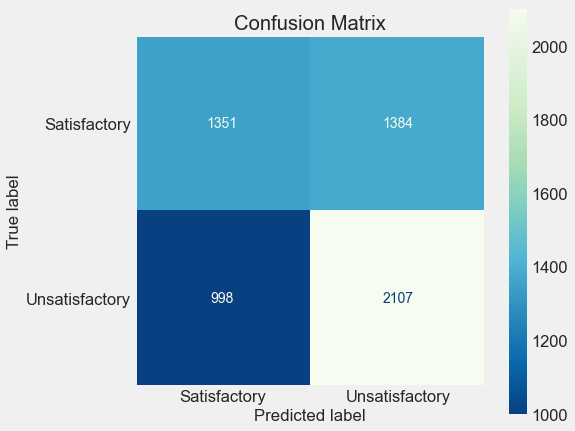

,Accuracy,F1,Recall,Precision
0,0.592123,0.638872,0.678583,0.603552


time: 20 s


In [57]:
f.confusion_report(svc, X_test, y_test)

## Linear Support Vector Machine

In [58]:
LSVC = LinearSVC()

time: 795 µs


In [59]:
lsvc = make_pipeline(preprocessing_ohe, LSVC)

time: 968 µs


### Fitting Model

In [60]:
lsvc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>)])),
                ('linearsvc', LinearSVC())])

time: 269 ms


In [61]:
# f.pickle_model(lsvc, 'lsvc')

time: 674 µs


### Cross Val Scores

In [62]:
# checking cross val scores
modeling.report(lsvc, X_train, y_train, 'lsvc', 'Linear SVC')

lsvc has an average Accuracy of 0.5960721860062542
lsvc has an average F1 of 0.6378643542264031
lsvc has an average Recall of 0.6691358024691357
lsvc has an average Precision of 0.6094955875821146


[0.5960721860062542,
 0.6378643542264031,
 0.6691358024691357,
 0.6094955875821146]

time: 1.3 s


### Test Data Confusion Matrix

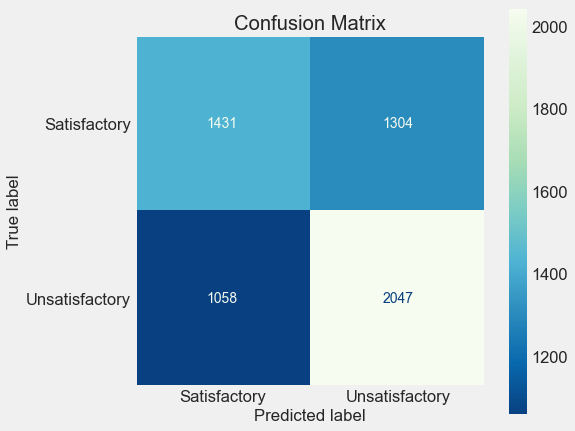

,Accuracy,F1,Recall,Precision
0,0.595548,0.634139,0.659259,0.610862


time: 259 ms


In [63]:
f.confusion_report(lsvc, X_test, y_test)

## Decision Tree

In [64]:
DT = DecisionTreeClassifier(random_state=2021)

time: 882 µs


In [65]:
dt = make_pipeline(preprocessing_ohe, DT)

time: 977 µs


### Fitting Model

In [66]:
dt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 308 ms


In [67]:
# f.pickle_model(dt, 'dt')

time: 678 µs


### Cross Val Scores

In [68]:
# checking cross val scores
modeling.report(dt, X_train, y_train, 'dt', 'Decision Tree')

dt has an average Accuracy of 0.5506333123467557
dt has an average F1 of 0.5622212347365302
dt has an average Recall of 0.5427804616210412
dt has an average Precision of 0.5832053074895044


[0.5506333123467557,
 0.5622212347365302,
 0.5427804616210412,
 0.5832053074895044]

time: 1.09 s


### Test Data Confusion Matrix

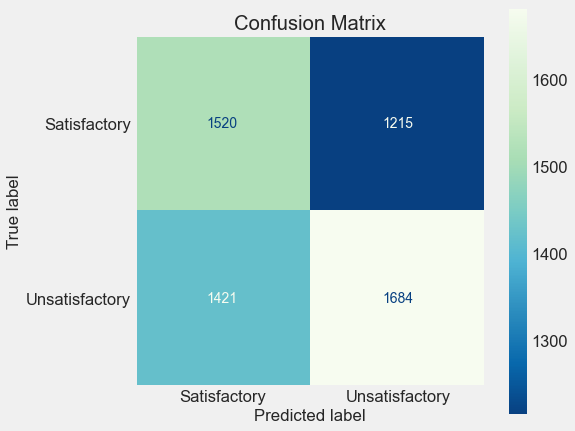

,Accuracy,F1,Recall,Precision
0,0.54863,0.560959,0.542351,0.58089


time: 256 ms


In [69]:
f.confusion_report(dt, X_test, y_test)

## Bagging Classifier

In [70]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 833 µs


In [71]:
bclf = make_pipeline(preprocessing_ohe, BCLF)

time: 1.12 ms


### Fitting Model

In [72]:
bclf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 1.83 s


In [73]:
# f.pickle_model(bclf, 'bclf')

time: 669 µs


### Cross Val Scores

In [74]:
# checking cross val scores
modeling.report(bclf, X_train, y_train, 'bclf', 'Bagging CLF')

bclf has an average Accuracy of 0.5514896885513656
bclf has an average F1 of 0.5890398847657412
bclf has an average Recall of 0.6045088566827698
bclf has an average Precision of 0.5743717386752488


[0.5514896885513656,
 0.5890398847657412,
 0.6045088566827698,
 0.5743717386752488]

time: 7.02 s


### Test Data Confusion Matrix

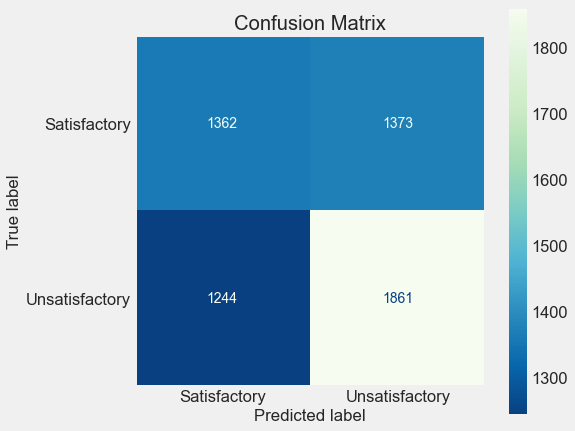

,Accuracy,F1,Recall,Precision
0,0.551884,0.587159,0.599356,0.575448


time: 338 ms


In [75]:
f.confusion_report(bclf, X_test, y_test)

## Random Forest Classifier

In [76]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 931 µs


In [77]:
rf = make_pipeline(preprocessing_ohe, RF)

time: 1.12 ms


### Fitting Model

In [78]:
rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.77 s


In [79]:
# f.pickle_model(rf, 'rf')

time: 697 µs


### Cross Val Scores

In [80]:
# checking cross val scores
modeling.report(rf, X_train, y_train, 'rf', 'Random Forest')

rf has an average Accuracy of 0.5581683573245112
rf has an average F1 of 0.5972251059962846
rf has an average Recall of 0.6161030595813204
rf has an average Precision of 0.5795256602352586


[0.5581683573245112,
 0.5972251059962846,
 0.6161030595813204,
 0.5795256602352586]

time: 13.6 s


### Test Data Confusion Matrix

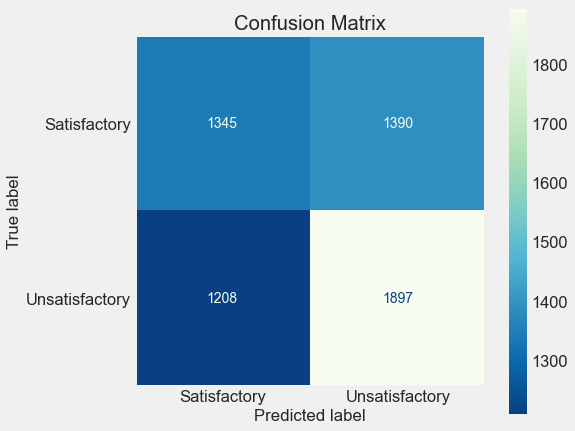

,Accuracy,F1,Recall,Precision
0,0.555137,0.593554,0.61095,0.577122


time: 593 ms


In [81]:
f.confusion_report(rf, X_test, y_test)

## AdaBoost

In [82]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 868 µs


In [83]:
ada = make_pipeline(preprocessing_ohe, ADA)

time: 985 µs


### Fitting Model

In [84]:
ada.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 1.58 s


In [85]:
# f.pickle_model(ada, 'ada')

time: 689 µs


### Cross Val Scores

In [86]:
# checking cross val scores
modeling.report(ada, X_train, y_train, 'ada', 'AdaBoost')

ada has an average Accuracy of 0.5533165962117271
ada has an average F1 of 0.5919711692314908
ada has an average Recall of 0.6093397745571659
ada has an average Precision of 0.5756395940493289


[0.5533165962117271,
 0.5919711692314908,
 0.6093397745571659,
 0.5756395940493289]

time: 6.31 s


### Test Data Confusion Matrix

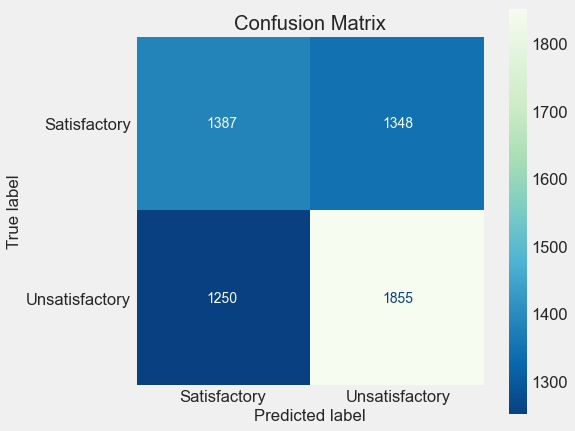

,Accuracy,F1,Recall,Precision
0,0.555137,0.588142,0.597424,0.579145


time: 466 ms


In [87]:
f.confusion_report(ada, X_test, y_test)

## XGBoost

In [88]:
XGB = XGBClassifier(use_label_encoder=False)

time: 1e+03 µs


In [89]:
xgb = make_pipeline(preprocessing_ohe, XGB)

time: 1 ms


### Fitting Model

In [90]:
%%capture --no-display
xgb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>)])),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               impo...pe='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
            

time: 666 ms


In [91]:
# f.pickle_model(xgb, 'xgb')

time: 742 µs


### Cross Val Scores

In [92]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb, X_train, y_train, 'xgb', 'XGBoost')

[0.5778627288807898,
 0.6152886925964351,
 0.6351046698872785,
 0.5968419250119308]

time: 2.88 s


### Test Data Confusion Matrix

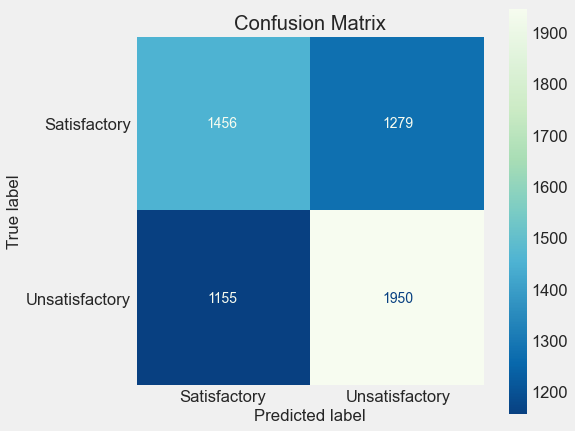

,Accuracy,F1,Recall,Precision
0,0.583219,0.615725,0.628019,0.603902


time: 483 ms


In [93]:
%%capture --no-display
f.confusion_report(xgb, X_test, y_test)

## Model Summary 1

In [94]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,dt,0.550633,0.562221,0.542780,0.583205,1.085123,Decision Tree
1,knn,0.547609,0.582077,0.592593,0.571965,12.251146,KNN
2,bclf,0.551490,0.589040,0.604509,0.574372,7.019714,Bagging CLF
3,ada,0.553317,0.591971,0.609340,0.575640,6.306130,AdaBoost
4,rf,0.558168,0.597225,0.616103,0.579526,13.588493,Random Forest
10,xgb,0.577863,0.615289,0.635105,0.596842,2.877623,XGBoost
5,fsm,0.591677,0.632245,0.660118,0.606662,0.360053,FSM Naive Bayes
6,lsvc,0.596072,0.637864,0.669136,0.609496,1.294234,Linear SVC
7,logreg,0.595958,0.637900,0.669458,0.609299,4.179869,Logistic Regression
8,svc,0.592876,0.639094,0.678690,0.604385,71.720253,Support Vector Classifier


time: 16.7 ms


# Adding STUDENTVLE Features
<font size=4>(click_sum, num_activities)</font>

In [95]:
df = db.sv_si()

time: 42.4 s


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29228 entries, 0 to 29227
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                29228 non-null  int64   
 1   row_id                29228 non-null  object  
 2   code_module           29228 non-null  object  
 3   code_presentation     29228 non-null  object  
 4   id_student            29228 non-null  object  
 5   id_site               29228 non-null  object  
 6   date                  29228 non-null  object  
 7   sum_click             29228 non-null  object  
 8   gender                29228 non-null  object  
 9   region                29228 non-null  object  
 10  highest_education     29228 non-null  object  
 11  imd_band              28174 non-null  object  
 12  age_band              29228 non-null  object  
 13  num_of_prev_attempts  29228 non-null  int64   
 14  studied_credits       29228 non-null  int64   
 15  di

In [97]:
drops = ['row_id', 'code_module', 'code_presentation', 'studied_credits',
         'id_student', 'id_site', 'date', 'sum_click', 'final_result']

time: 968 µs


In [98]:
df = db.pipe_cleaner(df, drops)

time: 91.5 ms


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26470 entries, 0 to 29227
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                26470 non-null  int64   
 1   gender                26470 non-null  object  
 2   region                26470 non-null  object  
 3   highest_education     26470 non-null  object  
 4   imd_band              26470 non-null  object  
 5   age_band              26470 non-null  object  
 6   num_of_prev_attempts  26470 non-null  int64   
 7   disability            26470 non-null  object  
 8   click_sum             26470 non-null  int64   
 9   num_activities        26470 non-null  int64   
 10  course_load           26470 non-null  category
dtypes: category(1), int64(4), object(6)
memory usage: 2.2+ MB
time: 17.5 ms


In [100]:
df.head()

,target,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,disability,click_sum,num_activities,course_load
0,0,Male,Yorkshire Region,A Level or Equivalent,20-30%,0-35,0,No,744,243,Light
1,0,Male,South Region,Lower Than A Level,80-90%,35-55,0,No,4104,913,Light
2,0,Male,North Western Region,A Level or Equivalent,30-40%,0-35,0,No,1944,781,Light
3,0,Male,London Region,HE Qualification,60-70%,0-35,0,No,1150,313,Light
4,0,Female,London Region,Lower Than A Level,30-40%,35-55,0,No,1896,572,Light


time: 12 ms


In [101]:
df.describe()

,target,num_of_prev_attempts,click_sum,num_activities
count,26470.000000,26470.000000,26470.000000,26470.000000
mean,0.469890,0.144125,1338.822629,360.084133
std,0.499102,0.452979,1719.149524,375.345601
min,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,259.000000,93.000000
50%,0.000000,0.000000,731.500000,239.000000
75%,1.000000,0.000000,1740.000000,500.000000
max,1.000000,6.000000,24139.000000,2953.000000


time: 21.3 ms


## Creating Holdout Data

In [102]:
# splitting data & target
X, y = f.X_y(df)

time: 8.92 ms


In [103]:
# splitting traing and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 17.5 ms


## Creating Training Data

In [104]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 18.9 ms


## MinMax Scaling
Since we've added numerical columns with very different scales to the data, we'll implement some scaling in the pipeline. K-Nearest Neighbors in particular is sensitive to differences in feature scale, and scaling can also help speed up convergence is certain algorithms.

## Naive Bayes Classifier

In [105]:
mnb_svsi = make_pipeline(preprocessing_mm, mnb)

time: 976 µs


### Fitting Model

In [106]:
mnb_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('multinomialnb', MultinomialNB())])

time: 70.6 ms


### Saving Model

In [107]:
# f.pickle_model(mnb_svsi, 'mnb_svsi')

time: 767 µs


### Cross Val Scores

In [108]:
# checking cross val scores
modeling.report(mnb_svsi, X_train, y_train, ' mnb_svsi',\
                'Naive Bayes SVSI/MinMax()')

 mnb_svsi has an average Accuracy of 0.6511515529965238
 mnb_svsi has an average F1 of 0.6004921499760085
 mnb_svsi has an average Recall of 0.5580313489226999
 mnb_svsi has an average Precision of 0.6499920377587581


[0.6511515529965238,
 0.6004921499760085,
 0.5580313489226999,
 0.6499920377587581]

time: 335 ms


### Test Data Confusion Matrix

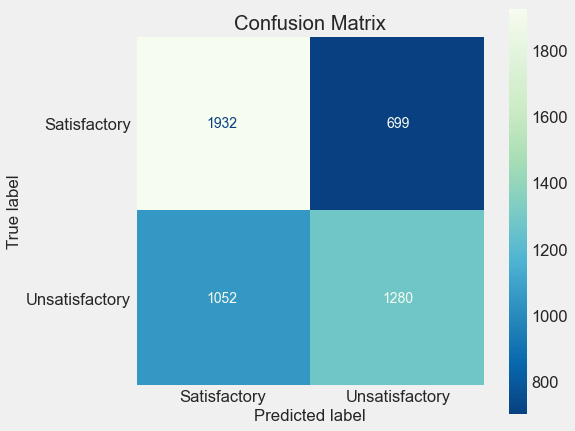

,Accuracy,F1,Recall,Precision
0,0.647189,0.59383,0.548885,0.646791


time: 269 ms


In [109]:
f.confusion_report(mnb_svsi, X_test, y_test)

## KNeighborsClassifier

In [110]:
knn_svsi = make_pipeline(preprocessing_mm, KNN)

time: 1.37 ms


### Fitting Model

In [111]:
knn_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 55.5 ms


In [112]:
# f.pickle_model(knn_svsi, 'knn_svsi')

time: 889 µs


### Cross Val Scores

In [113]:
# checking cross val scores
modeling.report(knn_svsi, X_train, y_train, 'knn_svsi',\
                'KNN SVSI/MinMax()')

knn_svsi has an average Accuracy of 0.6838607745570304
knn_svsi has an average F1 of 0.6586426638627266
knn_svsi has an average Recall of 0.6490860818952313
knn_svsi has an average Precision of 0.6684974392837131


[0.6838607745570304,
 0.6586426638627266,
 0.6490860818952313,
 0.6684974392837131]

time: 9.21 s


### Test Data Confusion Matrix

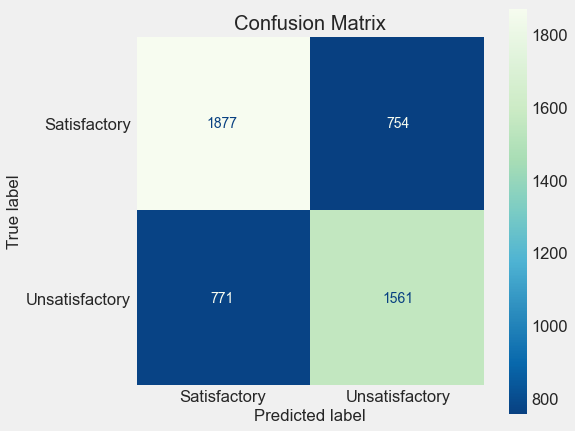

,Accuracy,F1,Recall,Precision
0,0.692726,0.671831,0.669383,0.674298


time: 18.5 s


In [114]:
f.confusion_report(knn_svsi, X_test, y_test)

## Logistic Regression Classifier

In [115]:
logreg_svsi = make_pipeline(preprocessing_mm, LR)

time: 915 µs


### Fitting Model

In [116]:
logreg_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 214 ms


In [117]:
# f.pickle_model(logreg_svsi, 'logreg_svsi')

time: 706 µs


### Cross Val Scores

In [118]:
# checking cross val scores
modeling.report(logreg_svsi, X_train, y_train, 'logreg_svsi',\
                'LogReg SVSI/MinMax()')

logreg_svsi has an average Accuracy of 0.7752698153946318
logreg_svsi has an average F1 of 0.7713370572078657
logreg_svsi has an average Recall of 0.806604002859185
logreg_svsi has an average Precision of 0.7391091970077099


[0.7752698153946318, 0.7713370572078657, 0.806604002859185, 0.7391091970077099]

time: 911 ms


### Test Data Confusion Matrix

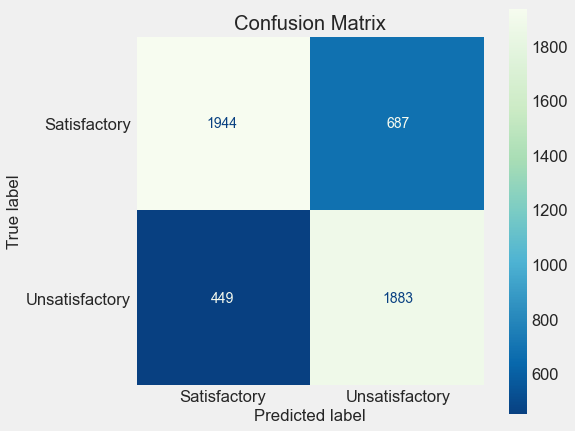

,Accuracy,F1,Recall,Precision
0,0.771106,0.768258,0.807461,0.732685


time: 233 ms


In [119]:
f.confusion_report(logreg_svsi, X_test, y_test)

## Support Vector Machine

In [120]:
svc_svsi= make_pipeline(preprocessing_mm, SVC)

time: 966 µs


### Fitting Model

In [121]:
svc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('svc', SVC())])

time: 13.7 s


In [122]:
# f.pickle_model(svc, 'svc_svsi')

time: 682 µs


### Cross Val Scores

In [123]:
# checking cross val scores
modeling.report(svc_svsi, X_train, y_train, 'svc_svsi',\
                'Support Vector CLF SVSI/MinMax()')

svc_svsi has an average Accuracy of 0.7586804182412148
svc_svsi has an average F1 of 0.755314293594922
svc_svsi has an average Recall of 0.7925952210762789
svc_svsi has an average Precision of 0.7214731939685197


[0.7586804182412148, 0.755314293594922, 0.7925952210762789, 0.7214731939685197]

time: 40.1 s


### Test Data Confusion Matrix

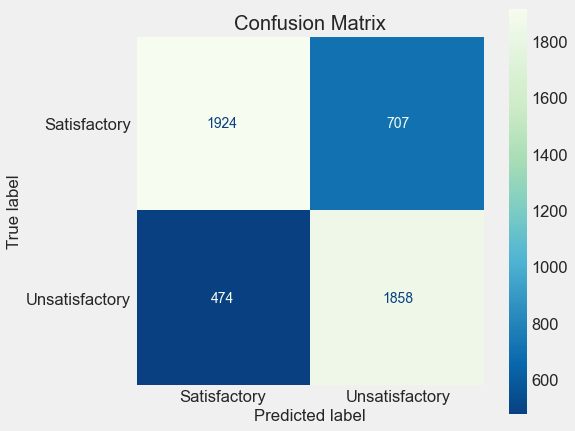

,Accuracy,F1,Recall,Precision
0,0.762039,0.758832,0.796741,0.724366


time: 11.8 s


In [124]:
f.confusion_report(svc_svsi, X_test, y_test)

## Linear Support Vector Machine

In [125]:
lsvc_svsi = make_pipeline(preprocessing_mm, LSVC)

time: 1.16 ms


### Fitting Model

In [126]:
lsvc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('linearsvc', LinearSVC())])

time: 227 ms


In [127]:
# f.pickle_model(lsvc_svsi, 'lsvc_svsi')

time: 662 µs


### Cross Val Scores

In [128]:
# checking cross val scores
modeling.report(lsvc_svsi, X_train, y_train, 'lsvc_svsi',\
                'Linear SVC SVSI/MinMax()')

lsvc_svsi has an average Accuracy of 0.7711732641092341
lsvc_svsi has an average F1 of 0.7707348320961438
lsvc_svsi has an average Recall of 0.818611048708261
lsvc_svsi has an average Precision of 0.728228844792579


[0.7711732641092341, 0.7707348320961438, 0.818611048708261, 0.728228844792579]

time: 1.21 s


### Test Data Confusion Matrix

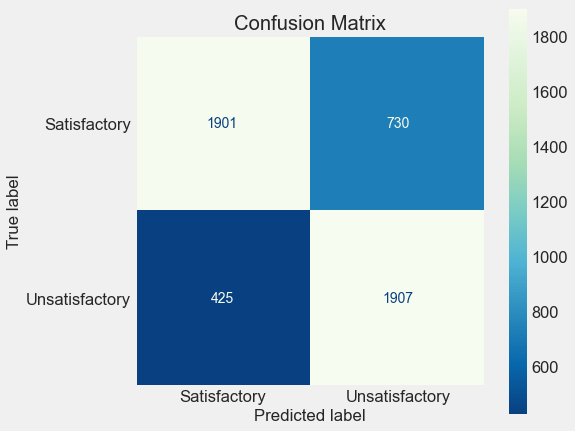

,Accuracy,F1,Recall,Precision
0,0.767278,0.767559,0.817753,0.72317


time: 383 ms


In [129]:
f.confusion_report(lsvc_svsi, X_test, y_test)

## Decision Tree

In [130]:
dt_svsi = make_pipeline(preprocessing_mm, DT)

time: 1.18 ms


### Fitting Model

In [131]:
dt_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 782 ms


In [132]:
# f.pickle_model(dt_svsi, 'dt_svsi')

time: 845 µs


### Cross Val Scores

In [133]:
# checking cross val scores
modeling.report(dt_svsi, X_train, y_train, 'dt_svsi',\
                'Decision Tree CLF SVSI/MinMax()')

dt_svsi has an average Accuracy of 0.713815725802904
dt_svsi has an average F1 of 0.6972835816297781
dt_svsi has an average Recall of 0.7015451853364648
dt_svsi has an average Precision of 0.6931909683478993


[0.713815725802904, 0.6972835816297781, 0.7015451853364648, 0.6931909683478993]

time: 1.95 s


### Test Data Confusion Matrix

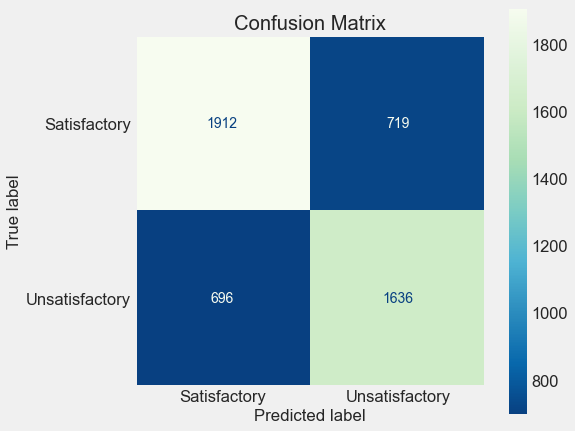

,Accuracy,F1,Recall,Precision
0,0.71489,0.698101,0.701544,0.694692


time: 284 ms


In [134]:
f.confusion_report(dt_svsi, X_test, y_test)

## Bagging Classifier

In [135]:
bclf_svsi = make_pipeline(preprocessing_mm, BCLF)

time: 907 µs


### Fitting Model

In [136]:
bclf_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 2.8 s


In [137]:
# f.pickle_model(bclf_svsi, 'bclf_svsi')

time: 637 µs


### Cross Val Scores

In [138]:
# checking cross val scores
modeling.report(bclf_svsi, X_train, y_train, 'bclf_svsi',\
                'Bagging CLF SVSI/MinMax()')

bclf_svsi has an average Accuracy of 0.7640543472645553
bclf_svsi has an average F1 of 0.7292893009821926
bclf_svsi has an average Recall of 0.6765289492494639
bclf_svsi has an average Precision of 0.791078275378512


[0.7640543472645553, 0.7292893009821926, 0.6765289492494639, 0.791078275378512]

time: 13.1 s


### Test Data Confusion Matrix

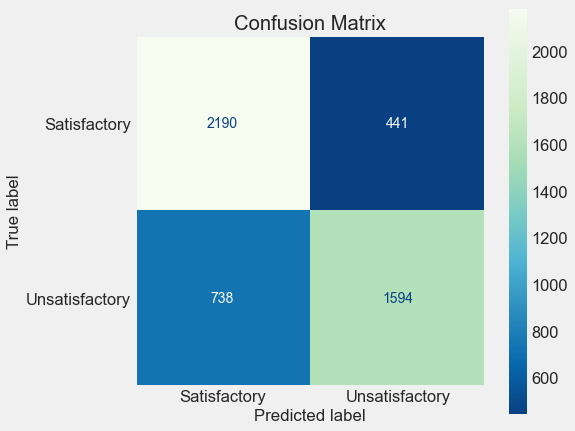

,Accuracy,F1,Recall,Precision
0,0.762442,0.730021,0.683533,0.783292


time: 340 ms


In [139]:
f.confusion_report(bclf_svsi, X_test, y_test)

## Random Forest Classifier

In [140]:
rf_svsi = make_pipeline(preprocessing_mm, RF)

time: 1.05 ms


### Fitting Model

In [141]:
rf_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.8 s


In [142]:
# f.pickle_model(rf_svsi, 'rf_svsi')

time: 655 µs


### Cross Val Scores

In [143]:
# checking cross val scores
modeling.report(rf_svsi, X_train, y_train, 'rf_svsi',\
                'Random Forest SVSI/MinMax()')

rf_svsi has an average Accuracy of 0.7768826054598575
rf_svsi has an average F1 of 0.7498473690552829
rf_svsi has an average Recall of 0.7118373327887266
rf_svsi has an average Precision of 0.792230079562219


[0.7768826054598575, 0.7498473690552829, 0.7118373327887266, 0.792230079562219]

time: 12.3 s


### Test Data Confusion Matrix

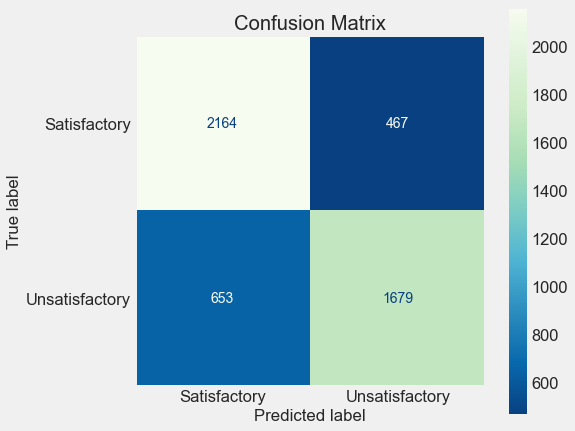

,Accuracy,F1,Recall,Precision
0,0.77433,0.749888,0.719983,0.782386


time: 653 ms


In [144]:
f.confusion_report(rf_svsi, X_test, y_test)

## AdaBoost

In [145]:
ada_svsi = make_pipeline(preprocessing_mm, ADA)

time: 1.1 ms


### Fitting Model

In [146]:
ada_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 571 ms


In [147]:
# f.pickle_model(ada_svsi, 'ada_svsi')

time: 689 µs


### Cross Val Scores

In [148]:
# checking cross val scores
modeling.report(ada_svsi, X_train, y_train, 'ada_svsi',\
                'AdaBoost SVSI/MinMax()')

ada_svsi has an average Accuracy of 0.7134796366952998
ada_svsi has an average F1 of 0.696720016390799
ada_svsi has an average Recall of 0.7005452874502195
ada_svsi has an average Precision of 0.6930858638492422


[0.7134796366952998, 0.696720016390799, 0.7005452874502195, 0.6930858638492422]

time: 2.1 s


### Test Data Confusion Matrix

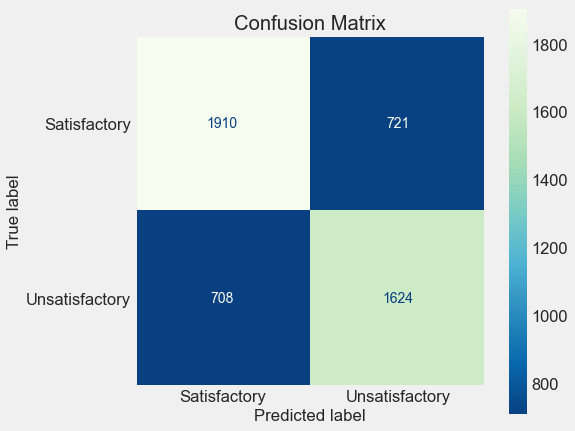

,Accuracy,F1,Recall,Precision
0,0.712069,0.694462,0.696398,0.692537


time: 293 ms


In [149]:
f.confusion_report(ada_svsi, X_test, y_test)

## XGBoost

In [150]:
xgb_svsi = make_pipeline(preprocessing_mm, XGB)

time: 1 ms


### Fitting Model

In [151]:
%%capture --no-display
xgb_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('xgbclassifier',
                 XGBClassifier(ba...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 1.54 s


In [152]:
# f.pickle_model(xgb_svsi, 'xgb_svsi')

time: 854 µs


### Cross Val Scores

In [153]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_svsi, X_train, y_train, 'xgb_svsi',\
                'XGBoost SVSI/MinMax()')

[0.7804414322205636,
 0.7525015005622014,
 0.7102636577146941,
 0.8001568893894099]

time: 6.42 s


### Test Data Confusion Matrix

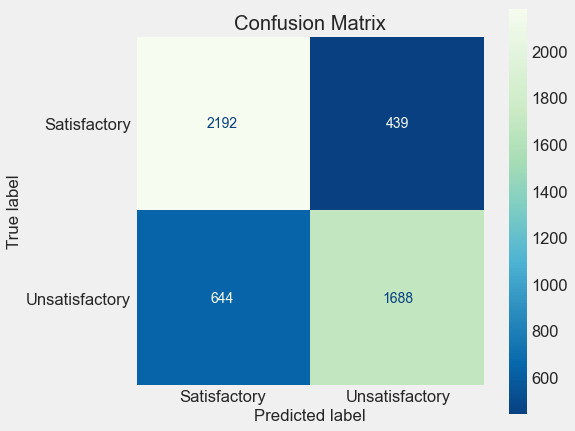

,Accuracy,F1,Recall,Precision
0,0.781785,0.75712,0.723842,0.793606


time: 423 ms


In [154]:
%%capture --no-display
f.confusion_report(xgb_svsi, X_test, y_test)

## Model Summary 2

In [155]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,dt,0.550633,0.562221,0.542780,0.583205,1.085123,Decision Tree
1,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.329554,Naive Bayes SVSI/MinMax()
2,knn,0.547609,0.582077,0.592593,0.571965,12.251146,KNN
3,bclf,0.551490,0.589040,0.604509,0.574372,7.019714,Bagging CLF
4,ada,0.553317,0.591971,0.609340,0.575640,6.306130,AdaBoost
5,rf,0.558168,0.597225,0.616103,0.579526,13.588493,Random Forest
6,xgb,0.577863,0.615289,0.635105,0.596842,2.877623,XGBoost
7,knn_svsi,0.683861,0.658643,0.649086,0.668497,9.199163,KNN SVSI/MinMax()
8,fsm,0.591677,0.632245,0.660118,0.606662,0.360053,FSM Naive Bayes
9,lsvc,0.596072,0.637864,0.669136,0.609496,1.294234,Linear SVC


time: 12.1 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [156]:
clf1 = LR
clf2 = SVC
clf3 = XGB

estimators = [('logreg', clf1), ('scv', clf2), ('lsvc',clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.45 ms


In [157]:
vc_svsi = make_pipeline(preprocessing_mm, VC)

time: 1.01 ms


### Fitting Model

In [158]:
%%capture --no-display
vc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('votingclassifier',
                 VotingClassif...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 11.3 s


In [159]:
# f.pickle_model(vc_svsi, 'vc_svsi')

time: 684 µs


### Cross Val Scores

In [160]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_svsi, X_train, y_train, 'vc_svsi',\
                'Voting CLF SVSI/MinMax()')

[0.7786279993493885, 0.769956071630871, 0.7883076687429798, 0.7525339045876993]

time: 45 s


### Test Data Confusion Matrix

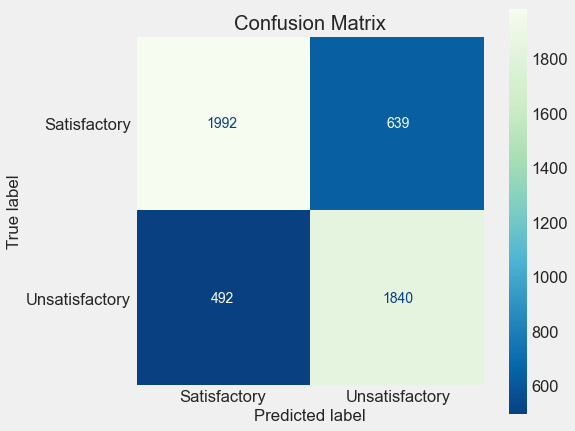

,Accuracy,F1,Recall,Precision
0,0.772114,0.764914,0.789022,0.742235


time: 12.1 s


In [161]:
%%capture --no-display
f.confusion_report(vc_svsi, X_test, y_test)

## Model Summary 3

In [162]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,dt,0.550633,0.562221,0.542780,0.583205,1.085123,Decision Tree
1,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.329554,Naive Bayes SVSI/MinMax()
2,knn,0.547609,0.582077,0.592593,0.571965,12.251146,KNN
3,bclf,0.551490,0.589040,0.604509,0.574372,7.019714,Bagging CLF
4,ada,0.553317,0.591971,0.609340,0.575640,6.306130,AdaBoost
5,rf,0.558168,0.597225,0.616103,0.579526,13.588493,Random Forest
6,xgb,0.577863,0.615289,0.635105,0.596842,2.877623,XGBoost
7,knn_svsi,0.683861,0.658643,0.649086,0.668497,9.199163,KNN SVSI/MinMax()
8,fsm,0.591677,0.632245,0.660118,0.606662,0.360053,FSM Naive Bayes
9,lsvc,0.596072,0.637864,0.669136,0.609496,1.294234,Linear SVC


time: 13.2 ms


## Neural Network

### Create Model

In [163]:
def create_model():
    # building model
    model = Sequential()
    model.add(Dense(64, input_dim=38, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

time: 1.32 ms


In [164]:
NN = KerasClassifier(build_fn=create_model,
                     epochs=10,
                     batch_size=32,
                     verbose=0)

time: 1.27 ms


### Pipeline

In [165]:
nn_svsi = make_pipeline(preprocessing_mm, NN)

time: 1.06 ms


### Fitting Models

In [166]:
# %%capture --no-display
nn_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1caef9340>)])

time: 6.73 s


In [167]:
# f.pickle_model(nn_svsi, 'nn_svsi')

time: 913 µs


### Cross Val Scores

In [168]:
%%capture --no-display
modeling.report(nn_svsi, X_train, y_train, 'nn_svsi',\
                'Neural Net SVSI/MinMax()')

[0.7848074774299402, 0.7473786564673711, 0.67808716027428, 0.8337107006965437]

time: 24.9 s


### Test Data Confusion Matrix

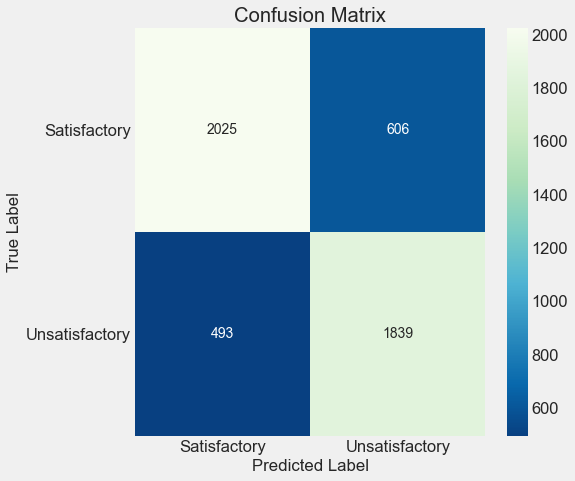

,Accuracy,F1,Recall,Precision
0,0.778561,0.769939,0.788593,0.752147


time: 747 ms


In [169]:
%%capture --no-display
f.confusion_report_nn(nn_svsi, X_test, y_test)

## Model Summary 4

In [170]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,dt,0.550633,0.562221,0.542780,0.583205,1.085123,Decision Tree
1,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.329554,Naive Bayes SVSI/MinMax()
2,knn,0.547609,0.582077,0.592593,0.571965,12.251146,KNN
3,bclf,0.551490,0.589040,0.604509,0.574372,7.019714,Bagging CLF
4,ada,0.553317,0.591971,0.609340,0.575640,6.306130,AdaBoost
5,rf,0.558168,0.597225,0.616103,0.579526,13.588493,Random Forest
6,xgb,0.577863,0.615289,0.635105,0.596842,2.877623,XGBoost
7,knn_svsi,0.683861,0.658643,0.649086,0.668497,9.199163,KNN SVSI/MinMax()
8,fsm,0.591677,0.632245,0.660118,0.606662,0.360053,FSM Naive Bayes
9,lsvc,0.596072,0.637864,0.669136,0.609496,1.294234,Linear SVC


time: 11.7 ms


In [171]:
%%capture --no-display
# df = modeling.history
# f.df_plot(df, 'modeling_history')

time: 1 ms


# Adding Assessment Data Features
<font size=4>(mean_score, median_score, weighted_ave)</font>

In [172]:
path = os.path.join(gparent, 'data/processed/df2.csv')
df = pd.read_csv(path)

time: 80.9 ms


In [173]:
# df.info()

time: 734 µs


In [174]:
df = db.df_a()

time: 47 s


In [175]:
drops = ['row_id', 'code_module', 'code_presentation', 'sum_click', 'date',
         'id_student', 'id_site', 'studied_credits', 'final_result']

time: 926 µs


In [176]:
# %%capture --no-display
df = db.pipe_cleaner_wa(df, drops)

time: 94.8 ms


In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22579 entries, 0 to 26330
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                22579 non-null  int64   
 1   gender                22579 non-null  object  
 2   region                22579 non-null  object  
 3   highest_education     22579 non-null  object  
 4   imd_band              22579 non-null  object  
 5   age_band              22579 non-null  object  
 6   num_of_prev_attempts  22579 non-null  int64   
 7   disability            22579 non-null  object  
 8   click_sum             22579 non-null  int64   
 9   num_activities        22579 non-null  int64   
 10  course_load           22579 non-null  category
 11  mean_score            22579 non-null  float64 
 12  median_score          22579 non-null  float64 
 13  weighted_ave          22579 non-null  float64 
dtypes: category(1), float64(3), int64(4), object(6)
memory

In [178]:
df.weighted_ave.describe()

count    22579.000000
mean        62.558422
std         47.311616
min          0.000000
25%         18.000000
50%         65.300000
75%         86.500000
max        195.640000
Name: weighted_ave, dtype: float64

time: 6.85 ms


## Creating Holdout Data

In [179]:
# splitting data & target
X, y = f.X_y(df)

time: 5.31 ms


In [180]:
# splitting traing and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 20.9 ms


## Creating Training Data

In [181]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 13.5 ms


## Naive Bayes Classifier

In [182]:
mnb_assess = make_pipeline(preprocessing_mm, mnb)

time: 1.09 ms


### Fitting Model

In [183]:
mnb_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('multinomialnb', MultinomialNB())])

time: 57.8 ms


### Saving Model

In [184]:
# f.pickle_model(mnb_assess, 'mnb_assess')

time: 896 µs


### Cross Val Scores

In [185]:
# checking cross val scores
modeling.report(mnb_assess, X_train, y_train, 'mnb_assess',\
                'Naive Bayes ASSESS/MinMax()')

mnb_assess has an average Accuracy of 0.6865354330708662
mnb_assess has an average F1 of 0.5720562024350198
mnb_assess has an average Recall of 0.4846994535519126
mnb_assess has an average Precision of 0.69787531235429


[0.6865354330708662, 0.5720562024350198, 0.4846994535519126, 0.69787531235429]

time: 336 ms


### Test Data Confusion Matrix

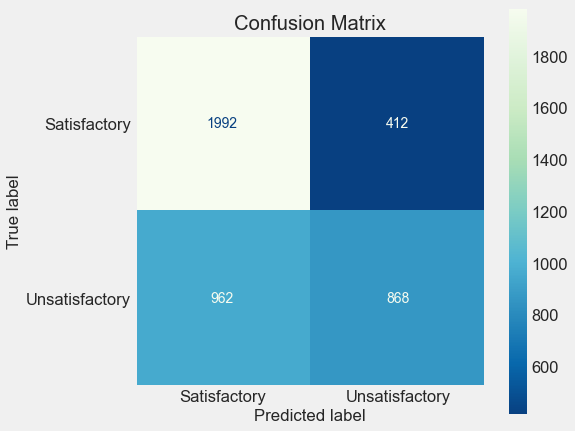

,Accuracy,F1,Recall,Precision
0,0.675484,0.558199,0.474317,0.678125


time: 263 ms


In [186]:
f.confusion_report(mnb_assess, X_test, y_test)

## KNeighborsClassifier

In [187]:
knn_assess = make_pipeline(preprocessing_mm, KNN)

time: 1.02 ms


### Fitting Model

In [188]:
knn_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 71.1 ms


In [189]:
# f.pickle_model(knn_assess, 'knn_assess')

time: 809 µs


### Cross Val Scores

In [190]:
# checking cross val scores
modeling.report(knn_assess, X_train, y_train, 'knn_assess',\
                'KNN ASSESS/MinMax()')

knn_assess has an average Accuracy of 0.6948031496062993
knn_assess has an average F1 of 0.622513889469355
knn_assess has an average Recall of 0.5821493624772313
knn_assess has an average Precision of 0.6690014893045196


[0.6948031496062993, 0.622513889469355, 0.5821493624772313, 0.6690014893045196]

time: 5.65 s


### Test Data Confusion Matrix

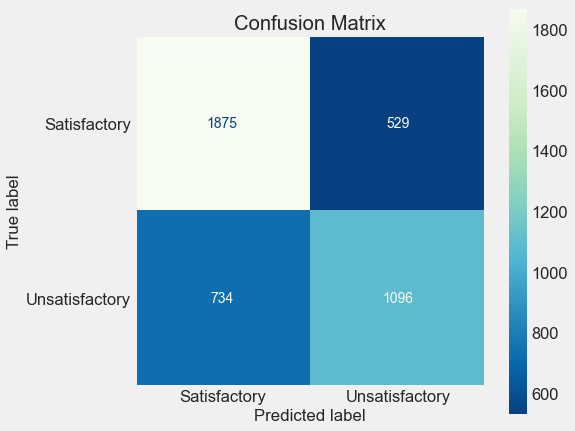

,Accuracy,F1,Recall,Precision
0,0.701701,0.634443,0.598907,0.674462


time: 11.9 s


In [191]:
f.confusion_report(knn_assess, X_test, y_test)

## Logistic Regression Classifier

In [192]:
logreg_assess = make_pipeline(preprocessing_mm, LR)

time: 965 µs


### Fitting Model

In [193]:
logreg_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 398 ms


In [194]:
# f.pickle_model(logreg_assess, 'logreg_assess')

time: 608 µs


### Cross Val Scores

In [195]:
# checking cross val scores
modeling.report(logreg_assess, X_train, y_train, 'logreg_assess',\
                'LogReg ASSESS/MinMax()')

logreg_assess has an average Accuracy of 0.7911023622047243
logreg_assess has an average F1 of 0.7559379279626353
logreg_assess has an average Recall of 0.7482695810564663
logreg_assess has an average Precision of 0.763810160081742


[0.7911023622047243, 0.7559379279626353, 0.7482695810564663, 0.763810160081742]

time: 1.03 s


### Test Data Confusion Matrix

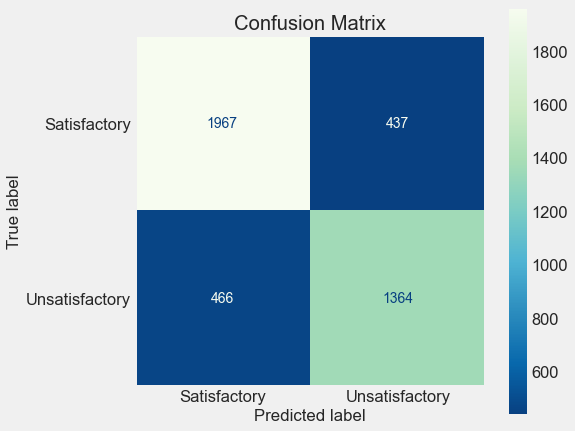

,Accuracy,F1,Recall,Precision
0,0.786726,0.751308,0.745355,0.757357


time: 243 ms


In [196]:
f.confusion_report(logreg_assess, X_test, y_test)

## Support Vector Machine

In [197]:
svc_assess= make_pipeline(preprocessing_mm, SVC)

time: 1.01 ms


### Fitting Model

In [198]:
svc_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('svc', SVC())])

time: 7 s


In [199]:
# f.pickle_model(svc_assess, 'svc_assess')

time: 687 µs


### Cross Val Scores

In [200]:
# checking cross val scores
modeling.report(svc_assess, X_train, y_train, 'svc_assess',\
                'Support Vector CLF ASSESS/MinMax()')

svc_assess has an average Accuracy of 0.7951181102362206
svc_assess has an average F1 of 0.7553263440385154
svc_assess has an average Recall of 0.731511839708561
svc_assess has an average Precision of 0.780793365078701


[0.7951181102362206, 0.7553263440385154, 0.731511839708561, 0.780793365078701]

time: 29.5 s


### Test Data Confusion Matrix

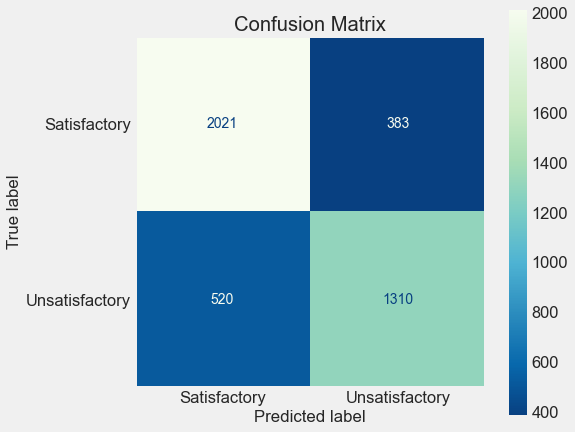

,Accuracy,F1,Recall,Precision
0,0.786726,0.743684,0.715847,0.773774


time: 7.77 s


In [201]:
f.confusion_report(svc_assess, X_test, y_test)

## Linear Support Vector Machine

In [202]:
lsvc_assess = make_pipeline(preprocessing_mm, LSVC)

time: 879 µs


### Fitting Model

In [203]:
lsvc_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('linearsvc', LinearSVC())])

time: 243 ms


In [204]:
# f.pickle_model(lsvc_assess, 'lsvc_assess')

time: 686 µs


### Cross Val Scores

In [205]:
# checking cross val scores
modeling.report(lsvc_assess, X_train, y_train, 'lsvc_assess',\
                'Linear SVC ASSESS/MinMax()')

lsvc_assess has an average Accuracy of 0.7921259842519686
lsvc_assess has an average F1 of 0.7583972092769592
lsvc_assess has an average Recall of 0.7546448087431694
lsvc_assess has an average Precision of 0.7622386299250709


[0.7921259842519686,
 0.7583972092769592,
 0.7546448087431694,
 0.7622386299250709]

time: 980 ms


### Test Data Confusion Matrix

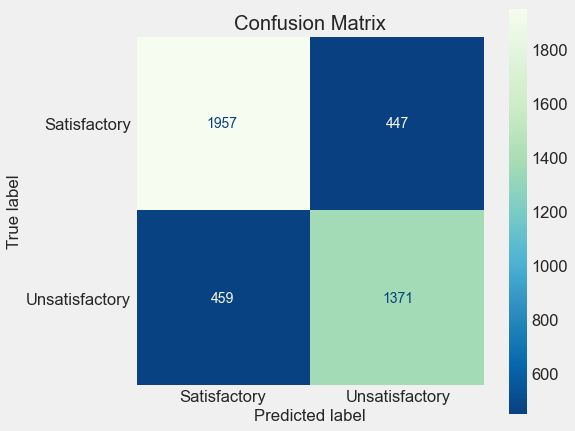

,Accuracy,F1,Recall,Precision
0,0.786018,0.751645,0.74918,0.754125


time: 286 ms


In [206]:
f.confusion_report(lsvc_assess, X_test, y_test)

## Decision Tree

In [207]:
dt_assess = make_pipeline(preprocessing_mm, DT)

time: 1.08 ms


### Fitting Model

In [208]:
dt_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 433 ms


In [209]:
# f.pickle_model(dt_assess, 'dt_assess')

time: 632 µs


### Cross Val Scores

In [210]:
# checking cross val scores
modeling.report(dt_assess, X_train, y_train, 'dt_assess',\
                'Decision Tree CLF ASSESS/MinMax()')

dt_assess has an average Accuracy of 0.8277165354330709
dt_assess has an average F1 of 0.8022213791262589
dt_assess has an average Recall of 0.8087431693989071
dt_assess has an average Precision of 0.7959979805431441


[0.8277165354330709,
 0.8022213791262589,
 0.8087431693989071,
 0.7959979805431441]

time: 1.61 s


### Test Data Confusion Matrix

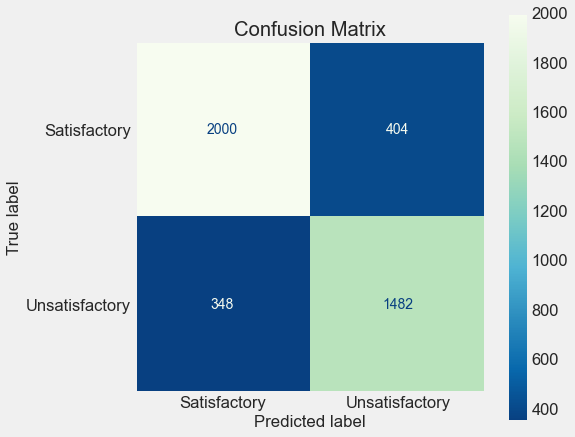

,Accuracy,F1,Recall,Precision
0,0.82239,0.797632,0.809836,0.78579


time: 249 ms


In [211]:
f.confusion_report(dt_assess, X_test, y_test)

## Bagging Classifier

In [212]:
bclf_assess = make_pipeline(preprocessing_mm, BCLF)

time: 979 µs


### Fitting Model

In [213]:
bclf_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 2.59 s


In [214]:
# f.pickle_model(bclf_assess, 'bclf_assess')

time: 763 µs


### Cross Val Scores

In [215]:
# checking cross val scores
modeling.report(bclf_assess, X_train, y_train, 'bclf_assess',\
                'Bagging CLF ASSESS/MinMax()')

bclf_assess has an average Accuracy of 0.8690551181102361
bclf_assess has an average F1 of 0.838374843839189
bclf_assess has an average Recall of 0.785792349726776
bclf_assess has an average Precision of 0.8985650363343053


[0.8690551181102361, 0.838374843839189, 0.785792349726776, 0.8985650363343053]

time: 11 s


### Test Data Confusion Matrix

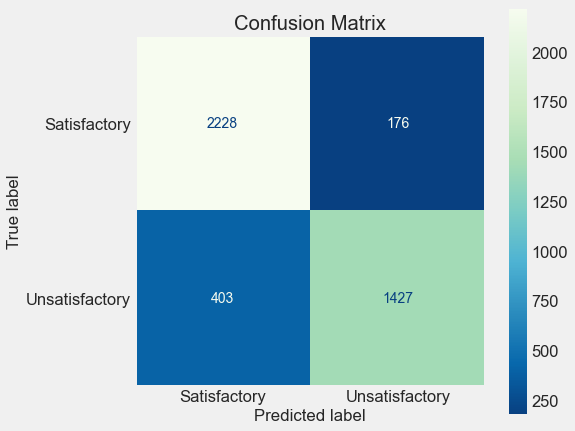

,Accuracy,F1,Recall,Precision
0,0.86325,0.831343,0.779781,0.890206


time: 392 ms


In [216]:
f.confusion_report(bclf_assess, X_test, y_test)

## Random Forest Classifier

In [217]:
rf_assess = make_pipeline(preprocessing_mm, RF)

time: 1.21 ms


### Fitting Model

In [218]:
rf_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.36 s


In [219]:
# f.pickle_model(rf_assess, 'rf_assess')

time: 718 µs


### Cross Val Scores

In [220]:
# checking cross val scores
modeling.report(rf_assess, X_train, y_train, 'rf_assess',\
                'Random Forest ASSESS/MinMax()')

rf_assess has an average Accuracy of 0.868976377952756
rf_assess has an average F1 of 0.841824283125959
rf_assess has an average Recall of 0.8067395264116577
rf_assess has an average Precision of 0.8801972515960749


[0.868976377952756, 0.841824283125959, 0.8067395264116577, 0.8801972515960749]

time: 10.9 s


### Test Data Confusion Matrix

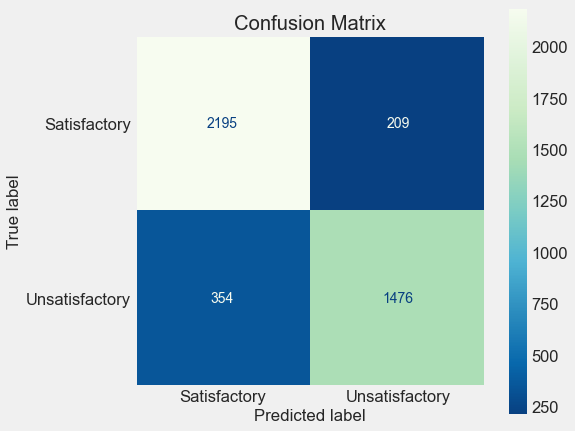

,Accuracy,F1,Recall,Precision
0,0.867029,0.839829,0.806557,0.875964


time: 901 ms


In [221]:
f.confusion_report(rf_assess, X_test, y_test)

## AdaBoost

In [222]:
ada_assess = make_pipeline(preprocessing_mm, ADA)

time: 2.42 ms


### Fitting Model

In [223]:
ada_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 709 ms


In [224]:
# f.pickle_model(ada_assess, 'ada_assess')

time: 1.1 ms


### Cross Val Scores

In [225]:
# checking cross val scores
modeling.report(ada_assess, X_train, y_train, 'ada_assess',\
                'AdaBoost ASSESS/MinMax()')

ada_assess has an average Accuracy of 0.8272440944881889
ada_assess has an average F1 of 0.8015262357552133
ada_assess has an average Recall of 0.8074681238615666
ada_assess has an average Precision of 0.7958654500688441


[0.8272440944881889,
 0.8015262357552133,
 0.8074681238615666,
 0.7958654500688441]

time: 2.32 s


### Test Data Confusion Matrix

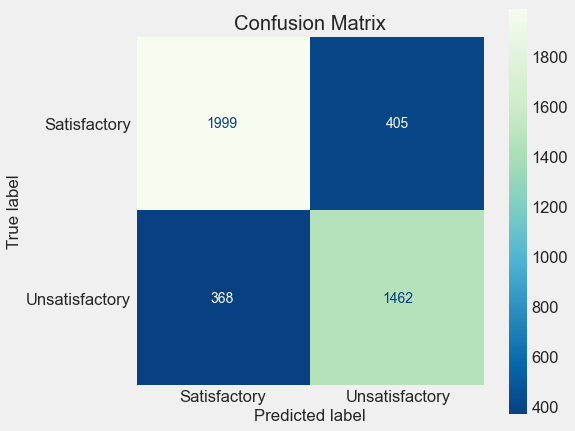

,Accuracy,F1,Recall,Precision
0,0.81743,0.790912,0.798907,0.783074


time: 275 ms


In [226]:
f.confusion_report(ada_assess, X_test, y_test)

## XGBoost

In [227]:
xgb_assess = make_pipeline(preprocessing_mm, XGB)

time: 2.04 ms


### Fitting Model

In [228]:
%%capture --no-display
xgb_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('xgbclassifier',
                 XGBClassifier(ba...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 2.05 s


In [229]:
# f.pickle_model(xgb_assess, 'xgb_assess')

time: 770 µs


### Cross Val Scores

In [230]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_assess, X_train, y_train, 'xgb_assess',\
                'XGBoost ASSESS/MinMax()')

[0.8701574803149607,
 0.8420762400105503,
 0.8010928961748632,
 0.8875615744698336]

time: 6.87 s


### Test Data Confusion Matrix

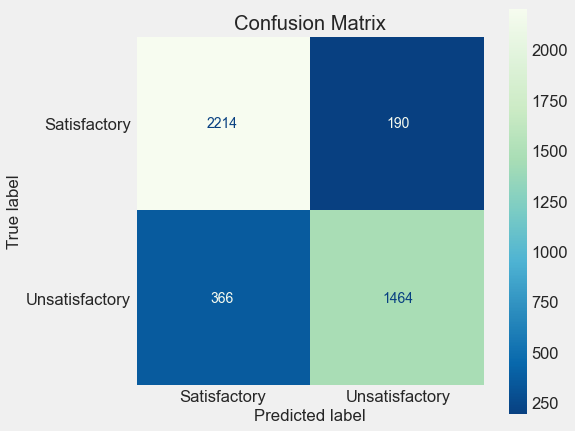

,Accuracy,F1,Recall,Precision
0,0.868682,0.840413,0.8,0.885127


time: 440 ms


In [231]:
%%capture --no-display
f.confusion_report(xgb_assess, X_test, y_test)

## Model Summary 5

In [232]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,mnb_assess,0.686535,0.572056,0.484699,0.697875,0.331339,Naive Bayes ASSESS/MinMax()
1,dt,0.550633,0.562221,0.542780,0.583205,1.085123,Decision Tree
2,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.329554,Naive Bayes SVSI/MinMax()
3,knn_assess,0.694803,0.622514,0.582149,0.669001,5.648315,KNN ASSESS/MinMax()
4,knn,0.547609,0.582077,0.592593,0.571965,12.251146,KNN
5,bclf,0.551490,0.589040,0.604509,0.574372,7.019714,Bagging CLF
6,ada,0.553317,0.591971,0.609340,0.575640,6.306130,AdaBoost
7,rf,0.558168,0.597225,0.616103,0.579526,13.588493,Random Forest
8,xgb,0.577863,0.615289,0.635105,0.596842,2.877623,XGBoost
9,knn_svsi,0.683861,0.658643,0.649086,0.668497,9.199163,KNN SVSI/MinMax()


time: 17.7 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [233]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf', clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.31 ms


In [234]:
vc_assess = make_pipeline(preprocessing_mm, VC)

time: 1.34 ms


### Fitting Model

In [235]:
%%capture --no-display
vc_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('votingclassifier',
                 VotingClassif...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 5.03 s


In [236]:
# f.pickle_model(vc_assess, 'vc_assess')

time: 712 µs


### Cross Val Scores

In [237]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_assess, X_train, y_train, 'vc_assess',\
                'Voting CLF ASSESS/MinMax()')

[0.8740157480314961, 0.8458532120513734, 0.8, 0.8973679312533642]

time: 19.1 s


### Test Data Confusion Matrix

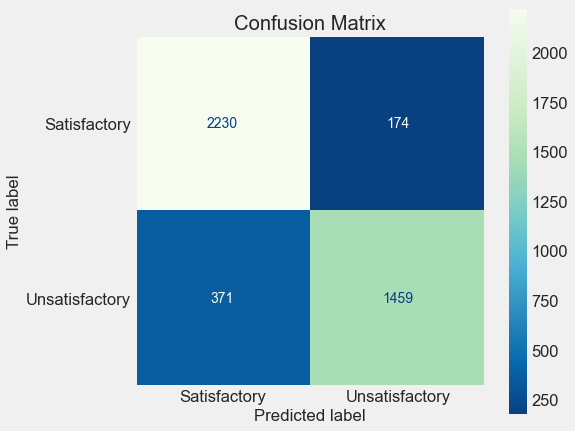

,Accuracy,F1,Recall,Precision
0,0.87128,0.842622,0.797268,0.893448


time: 998 ms


In [238]:
%%capture --no-display
f.confusion_report(vc_assess, X_test, y_test)

## Model Summary 6

In [239]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,mnb_assess,0.686535,0.572056,0.484699,0.697875,0.331339,Naive Bayes ASSESS/MinMax()
1,dt,0.550633,0.562221,0.542780,0.583205,1.085123,Decision Tree
2,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.329554,Naive Bayes SVSI/MinMax()
3,knn_assess,0.694803,0.622514,0.582149,0.669001,5.648315,KNN ASSESS/MinMax()
4,knn,0.547609,0.582077,0.592593,0.571965,12.251146,KNN
5,bclf,0.551490,0.589040,0.604509,0.574372,7.019714,Bagging CLF
6,ada,0.553317,0.591971,0.609340,0.575640,6.306130,AdaBoost
7,rf,0.558168,0.597225,0.616103,0.579526,13.588493,Random Forest
8,xgb,0.577863,0.615289,0.635105,0.596842,2.877623,XGBoost
9,knn_svsi,0.683861,0.658643,0.649086,0.668497,9.199163,KNN SVSI/MinMax()


time: 14.8 ms


## Neural Network

In [240]:
def create_model():
    # building model
    model = Sequential()
    model.add(Dense(64, input_dim=41, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

time: 1.39 ms


In [241]:
NN2 = KerasClassifier(build_fn=create_model,
                     epochs=10,
                     batch_size=32,
                     verbose=0)

time: 1.75 ms


### Pipeline

In [242]:
nn_assess = make_pipeline(preprocessing_mm, NN2)

time: 1.06 ms


### Fitting Models

In [243]:
%%capture --no-display
nn_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1cb6de190>)])

time: 5.09 s


In [244]:
# f.pickle_model(nn_assess, 'nn_assess')

time: 718 µs


### Cross Val Scores

In [245]:
%%capture --no-display
modeling.report(nn_assess, X_train, y_train, 'nn_assess',\
                'Neural Net ASSESS/MinMax()')

[0.794724409448819, 0.759625104779303, 0.7503296553031895, 0.7695358387591391]

time: 24.3 s


### Test Data Confusion Matrix

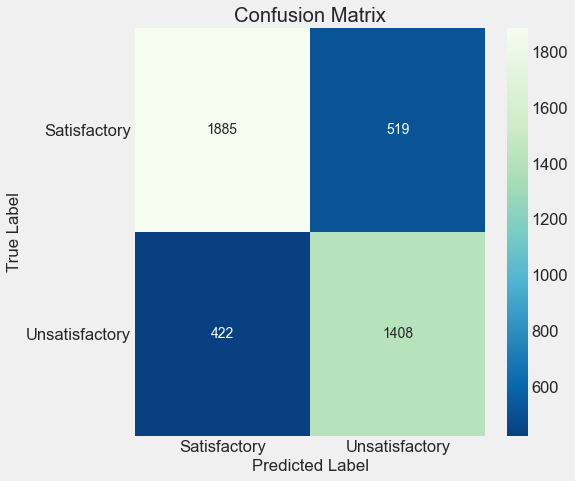

,Accuracy,F1,Recall,Precision
0,0.777752,0.749534,0.769399,0.730669


time: 694 ms


In [246]:
%%capture --no-display
f.confusion_report_nn(nn_assess, X_test, y_test)

## Model Summary 7

In [247]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,mnb_assess,0.686535,0.572056,0.484699,0.697875,0.331339,Naive Bayes ASSESS/MinMax()
1,dt,0.550633,0.562221,0.542780,0.583205,1.085123,Decision Tree
2,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.329554,Naive Bayes SVSI/MinMax()
3,knn_assess,0.694803,0.622514,0.582149,0.669001,5.648315,KNN ASSESS/MinMax()
4,knn,0.547609,0.582077,0.592593,0.571965,12.251146,KNN
5,bclf,0.551490,0.589040,0.604509,0.574372,7.019714,Bagging CLF
6,ada,0.553317,0.591971,0.609340,0.575640,6.306130,AdaBoost
7,rf,0.558168,0.597225,0.616103,0.579526,13.588493,Random Forest
8,xgb,0.577863,0.615289,0.635105,0.596842,2.877623,XGBoost
9,knn_svsi,0.683861,0.658643,0.649086,0.668497,9.199163,KNN SVSI/MinMax()


time: 17.3 ms


# SS Test

## KNeighborsClassifier

In [248]:
knn_ss = make_pipeline(preprocessing_ss, KNN)

time: 975 µs


### Fitting Model

In [249]:
knn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 86.7 ms


In [250]:
# f.pickle_model(knn_ss, 'knn_ss')

time: 961 µs


### Cross Val Scores

In [251]:
# checking cross val scores
modeling.report(knn_ss, X_train, y_train, 'knn_ss',\
                'KNN SS()')

knn_ss has an average Accuracy of 0.7903937007874016
knn_ss has an average F1 of 0.7483930095135466
knn_ss has an average Recall of 0.7211293260473589
knn_ss has an average Precision of 0.7778498355442294


[0.7903937007874016,
 0.7483930095135466,
 0.7211293260473589,
 0.7778498355442294]

time: 6.33 s


### Test Data Confusion Matrix

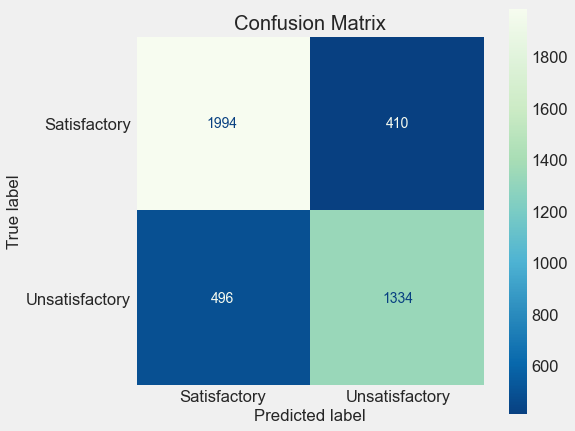

,Accuracy,F1,Recall,Precision
0,0.786018,0.746503,0.728962,0.764908


time: 15 s


In [252]:
f.confusion_report(knn_ss, X_test, y_test)

## Logistic Regression Classifier

In [253]:
logreg_ss = make_pipeline(preprocessing_ss, LR)

time: 1.17 ms


### Fitting Model

In [254]:
logreg_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 344 ms


In [255]:
# f.pickle_model(logreg_ss, 'logreg_ss')

time: 802 µs


### Cross Val Scores

In [256]:
# checking cross val scores
modeling.report(logreg_ss, X_train, y_train, 'logreg_ss',\
                'LogReg SS()')

logreg_ss has an average Accuracy of 0.7929921259842518
logreg_ss has an average F1 of 0.75864501281507
logreg_ss has an average Recall of 0.7524590163934425
logreg_ss has an average Precision of 0.7650172628729759


[0.7929921259842518, 0.75864501281507, 0.7524590163934425, 0.7650172628729759]

time: 985 ms


### Test Data Confusion Matrix

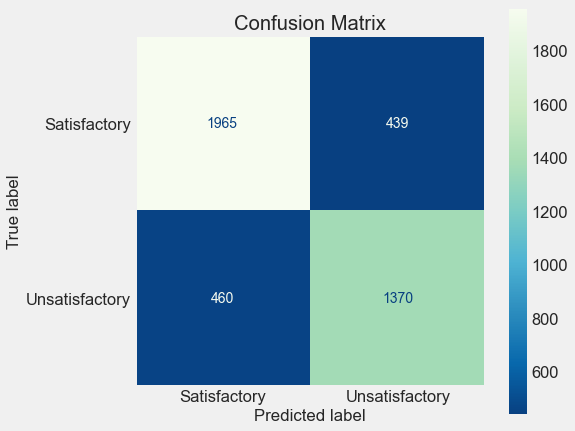

,Accuracy,F1,Recall,Precision
0,0.787671,0.752954,0.748634,0.757324


time: 243 ms


In [257]:
f.confusion_report(logreg_ss, X_test, y_test)

## Support Vector Machine

In [258]:
svc_ss = make_pipeline(preprocessing_ss, SVC)

time: 897 µs


### Fitting Model

In [259]:
svc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('svc', SVC())])

time: 8 s


In [260]:
# f.pickle_model(svc_ss, 'svc_ss')

time: 794 µs


### Cross Val Scores

In [261]:
# checking cross val scores
modeling.report(svc_ss, X_train, y_train, 'svc_ss',\
                'Support Vector CLF SS()')

svc_ss has an average Accuracy of 0.8284251968503937
svc_ss has an average F1 of 0.7950030534700916
svc_ss has an average Recall of 0.7695810564663024
svc_ss has an average Precision of 0.8222218442865434


[0.8284251968503937,
 0.7950030534700916,
 0.7695810564663024,
 0.8222218442865434]

time: 24.1 s


### Test Data Confusion Matrix

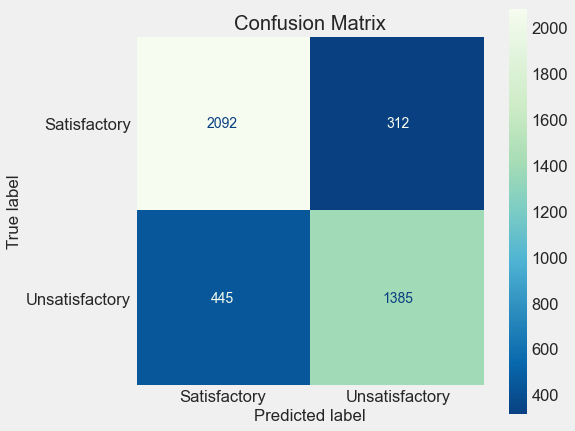

,Accuracy,F1,Recall,Precision
0,0.821209,0.78537,0.756831,0.816146


time: 6.68 s


In [262]:
f.confusion_report(svc_ss, X_test, y_test)

## Linear Support Vector Machine

In [263]:
lsvc_ss = make_pipeline(preprocessing_ss, LSVC)

time: 830 µs


### Fitting Model

In [264]:
lsvc_ss.fit(X_train, y_train)

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('linearsvc', LinearSVC())])

time: 874 ms


In [265]:
# f.pickle_model(lsvc_ss, 'lsvc_ss')

time: 611 µs


### Cross Val Scores

In [266]:
# checking cross val scores
modeling.report(lsvc_ss, X_train, y_train, 'lsvc_ss',\
                'Linear SVC SS()')

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


lsvc_ss has an average Accuracy of 0.7923622047244094
lsvc_ss has an average F1 of 0.7587830568079957
lsvc_ss has an average Recall of 0.7553734061930782
lsvc_ss has an average Precision of 0.7622875588424195


/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[0.7923622047244094,
 0.7587830568079957,
 0.7553734061930782,
 0.7622875588424195]

time: 3.06 s


### Test Data Confusion Matrix

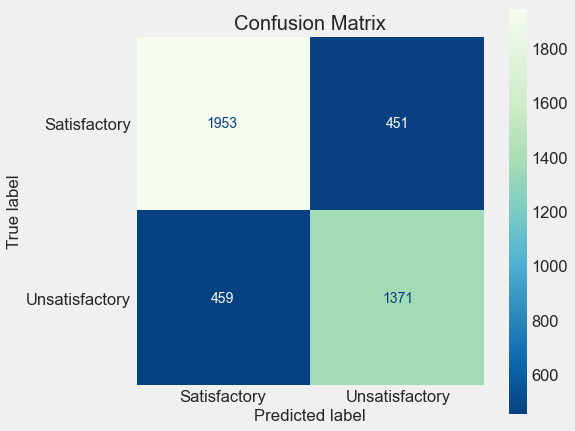

,Accuracy,F1,Recall,Precision
0,0.785073,0.750821,0.74918,0.75247


time: 234 ms


In [267]:
f.confusion_report(lsvc_ss, X_test, y_test)

## Decision Tree

In [268]:
dt_ss = make_pipeline(preprocessing_ss, DT)

time: 985 µs


### Fitting Model

In [269]:
dt_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 415 ms


In [270]:
# f.pickle_model(dt_ss, 'dt_ss')

time: 626 µs


### Cross Val Scores

In [271]:
# checking cross val scores
modeling.report(dt_ss, X_train, y_train, 'dt_ss',\
                'Decision Tree CLF SS()')

dt_ss has an average Accuracy of 0.8279527559055119
dt_ss has an average F1 of 0.8024053808929705
dt_ss has an average Recall of 0.8085610200364298
dt_ss has an average Precision of 0.7965412259496452


[0.8279527559055119,
 0.8024053808929705,
 0.8085610200364298,
 0.7965412259496452]

time: 1.67 s


### Test Data Confusion Matrix

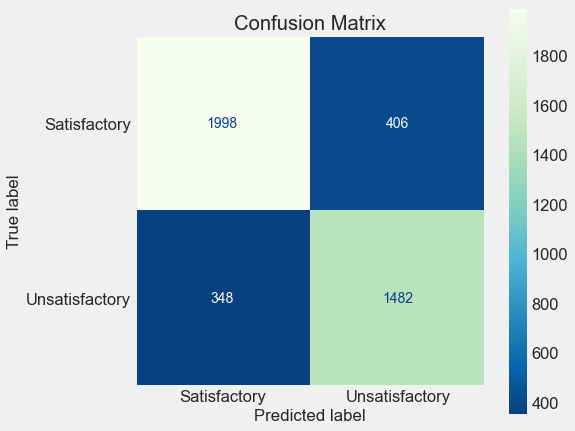

,Accuracy,F1,Recall,Precision
0,0.821918,0.797203,0.809836,0.784958


time: 209 ms


In [272]:
f.confusion_report(dt_ss, X_test, y_test)

## Bagging Classifier

In [273]:
bclf_ss = make_pipeline(preprocessing_ss, BCLF)

time: 890 µs


### Fitting Model

In [274]:
bclf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 2.54 s


In [275]:
# f.pickle_model(bclf_ss, 'bclf_ss')

time: 619 µs


### Cross Val Scores

In [276]:
# checking cross val scores
modeling.report(bclf_ss, X_train, y_train, 'bclf_ss',\
                'Bagging CLF SS()')

bclf_ss has an average Accuracy of 0.8690551181102363
bclf_ss has an average F1 of 0.8384417725985701
bclf_ss has an average Recall of 0.7861566484517304
bclf_ss has an average Precision of 0.8982379732413198


[0.8690551181102363,
 0.8384417725985701,
 0.7861566484517304,
 0.8982379732413198]

time: 9.15 s


### Test Data Confusion Matrix

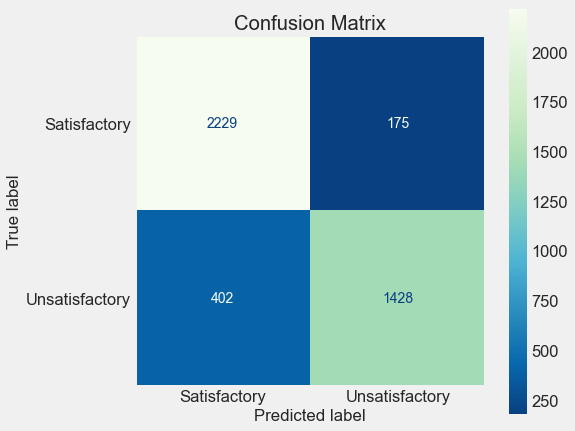

,Accuracy,F1,Recall,Precision
0,0.863722,0.831925,0.780328,0.89083


time: 285 ms


In [277]:
f.confusion_report(bclf_ss, X_test, y_test)

## Random Forest Classifier

In [278]:
rf_ss = make_pipeline(preprocessing_ss, RF)

time: 931 µs


### Fitting Model

In [279]:
rf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 1.99 s


In [280]:
# f.pickle_model(rf_ss, 'rf_ss')

time: 682 µs


### Cross Val Scores

In [281]:
# checking cross val scores
modeling.report(rf_ss, X_train, y_train, 'rf_ss',\
                'Random Forest SS()')

rf_ss has an average Accuracy of 0.8688976377952755
rf_ss has an average F1 of 0.8416807641384978
rf_ss has an average Recall of 0.8063752276867031
rf_ss has an average Precision of 0.8803216697684787


[0.8688976377952755,
 0.8416807641384978,
 0.8063752276867031,
 0.8803216697684787]

time: 10.3 s


### Test Data Confusion Matrix

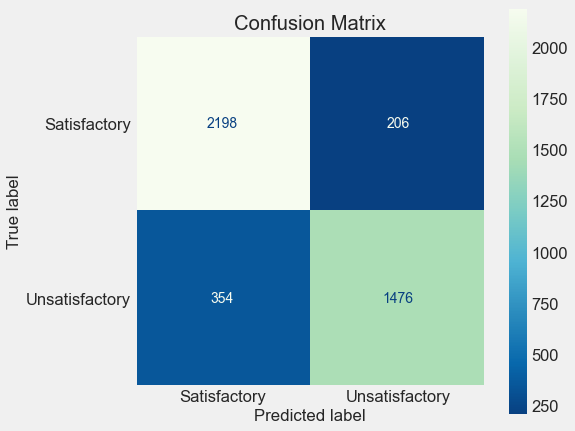

,Accuracy,F1,Recall,Precision
0,0.867737,0.840547,0.806557,0.877527


time: 467 ms


In [282]:
f.confusion_report(rf_ss, X_test, y_test)

## AdaBoost

In [283]:
ada_ss = make_pipeline(preprocessing_ss, ADA)

time: 975 µs


### Fitting Model

In [284]:
ada_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 445 ms


In [285]:
# f.pickle_model(ada_ss, 'ada_ss')

time: 709 µs


### Cross Val Scores

In [286]:
# checking cross val scores
modeling.report(ada_ss, X_train, y_train, 'ada_ss',\
                'AdaBoost SS()')

ada_ss has an average Accuracy of 0.8272440944881889
ada_ss has an average F1 of 0.8014247656025457
ada_ss has an average Recall of 0.8069216757741348
ada_ss has an average Precision of 0.7961835863036683


[0.8272440944881889,
 0.8014247656025457,
 0.8069216757741348,
 0.7961835863036683]

time: 1.81 s


### Test Data Confusion Matrix

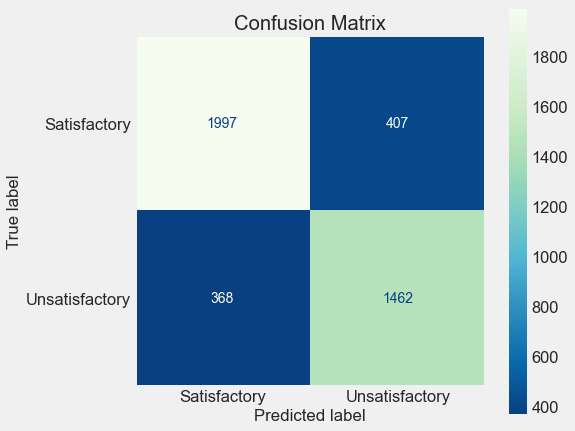

,Accuracy,F1,Recall,Precision
0,0.816958,0.790484,0.798907,0.782236


time: 222 ms


In [287]:
f.confusion_report(ada_ss, X_test, y_test)

## XGBoost

In [288]:
xgb_ss = make_pipeline(preprocessing_ss, XGB)

time: 918 µs


### Fitting Model

In [289]:
%%capture --no-display
xgb_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('xgbclassifier',
                 XGBClassifie...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 1.25 s


In [290]:
# f.pickle_model(xgb_ss, 'xgb_ss')

time: 836 µs


### Cross Val Scores

In [291]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_ss, X_train, y_train, 'xgb_ss',\
                'XGBoost SS()')

[0.872992125984252, 0.8463126856329085, 0.8091074681238617, 0.8872161633572453]

time: 6.35 s


### Test Data Confusion Matrix

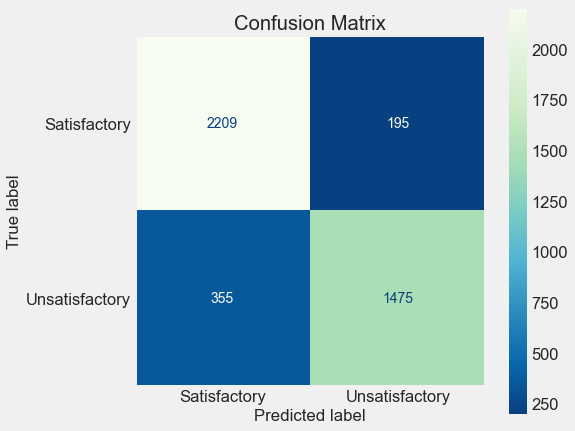

,Accuracy,F1,Recall,Precision
0,0.870099,0.842857,0.806011,0.883234


time: 535 ms


In [292]:
%%capture --no-display
f.confusion_report(xgb_ss, X_test, y_test)

## Model Summary 8

In [293]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,mnb_assess,0.686535,0.572056,0.484699,0.697875,0.331339,Naive Bayes ASSESS/MinMax()
1,dt,0.550633,0.562221,0.542780,0.583205,1.085123,Decision Tree
2,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.329554,Naive Bayes SVSI/MinMax()
3,knn_assess,0.694803,0.622514,0.582149,0.669001,5.648315,KNN ASSESS/MinMax()
4,knn,0.547609,0.582077,0.592593,0.571965,12.251146,KNN
5,bclf,0.551490,0.589040,0.604509,0.574372,7.019714,Bagging CLF
6,ada,0.553317,0.591971,0.609340,0.575640,6.306130,AdaBoost
7,rf,0.558168,0.597225,0.616103,0.579526,13.588493,Random Forest
8,xgb,0.577863,0.615289,0.635105,0.596842,2.877623,XGBoost
9,knn_svsi,0.683861,0.658643,0.649086,0.668497,9.199163,KNN SVSI/MinMax()


time: 26.1 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [294]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf',clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.56 ms


In [295]:
vc_ss = make_pipeline(preprocessing_ss, VC)

time: 943 µs


### Fitting Model

In [296]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('votingclassifier',
                 VotingCla...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 5.19 s


In [297]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 857 µs


### Cross Val Scores

In [298]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()')

[0.8748031496062992,
 0.8468646800543347,
 0.8010928961748635,
 0.8983028197155722]

time: 20.2 s


### Test Data Confusion Matrix

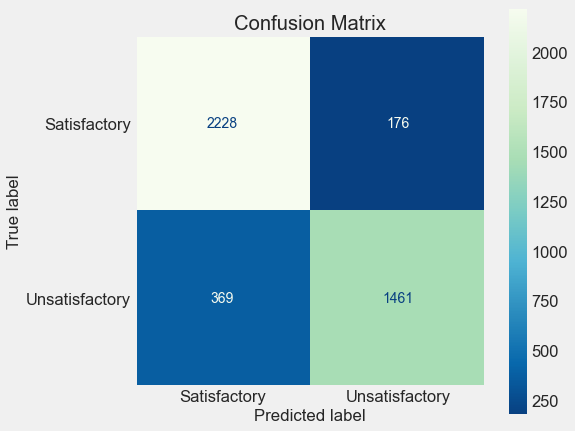

,Accuracy,F1,Recall,Precision
0,0.87128,0.842804,0.798361,0.892486


time: 922 ms


In [299]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary 9

In [300]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,mnb_assess,0.686535,0.572056,0.484699,0.697875,0.331339,Naive Bayes ASSESS/MinMax()
1,dt,0.550633,0.562221,0.542780,0.583205,1.085123,Decision Tree
2,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.329554,Naive Bayes SVSI/MinMax()
3,knn_assess,0.694803,0.622514,0.582149,0.669001,5.648315,KNN ASSESS/MinMax()
4,knn,0.547609,0.582077,0.592593,0.571965,12.251146,KNN
5,bclf,0.551490,0.589040,0.604509,0.574372,7.019714,Bagging CLF
6,ada,0.553317,0.591971,0.609340,0.575640,6.306130,AdaBoost
7,rf,0.558168,0.597225,0.616103,0.579526,13.588493,Random Forest
8,xgb,0.577863,0.615289,0.635105,0.596842,2.877623,XGBoost
9,knn_svsi,0.683861,0.658643,0.649086,0.668497,9.199163,KNN SVSI/MinMax()


time: 17.2 ms


## Neural Network

### Pipeline

In [301]:
nn_ss = make_pipeline(preprocessing_ss, NN2)

time: 927 µs


### Fitting Models

In [302]:
%%capture --no-display
nn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca550>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1046ca310>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1cb6de190>)])

time: 5.08 s


In [303]:
# f.pickle_model(nn_ss, 'nn_ss')

time: 733 µs


### Cross Val Scores

In [304]:
%%capture --no-display
modeling.report(nn_ss, X_train, y_train, 'nn_ss',\
                'Neural Net SS()')

[0.8562992125984252, 0.8183268664972767, 0.749943967483744, 0.901397249917798]

time: 23.3 s


### Test Data Confusion Matrix

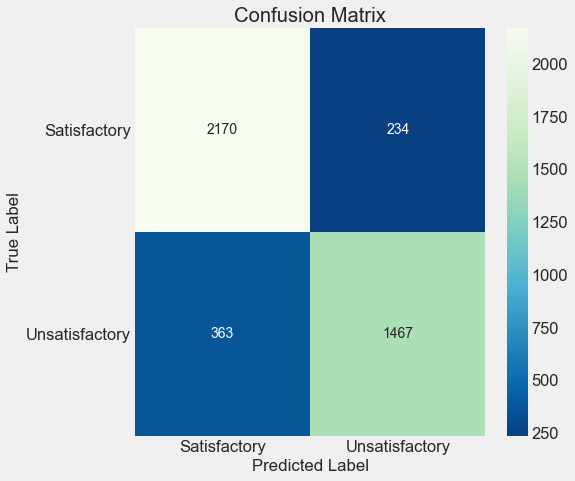

,Accuracy,F1,Recall,Precision
0,0.858999,0.830926,0.801639,0.862434


time: 622 ms


In [305]:
%%capture --no-display
f.confusion_report_nn(nn_ss, X_test, y_test)

## Model Summary 10

In [306]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,mnb_assess,0.686535,0.572056,0.484699,0.697875,0.331339,Naive Bayes ASSESS/MinMax()
1,dt,0.550633,0.562221,0.542780,0.583205,1.085123,Decision Tree
2,mnb_svsi,0.651152,0.600492,0.558031,0.649992,0.329554,Naive Bayes SVSI/MinMax()
3,knn_assess,0.694803,0.622514,0.582149,0.669001,5.648315,KNN ASSESS/MinMax()
4,knn,0.547609,0.582077,0.592593,0.571965,12.251146,KNN
5,bclf,0.551490,0.589040,0.604509,0.574372,7.019714,Bagging CLF
6,ada,0.553317,0.591971,0.609340,0.575640,6.306130,AdaBoost
7,rf,0.558168,0.597225,0.616103,0.579526,13.588493,Random Forest
8,xgb,0.577863,0.615289,0.635105,0.596842,2.877623,XGBoost
9,knn_svsi,0.683861,0.658643,0.649086,0.668497,9.199163,KNN SVSI/MinMax()


time: 16.8 ms


In [307]:
Audio(sound_file, autoplay=True)

time: 239 ms


In [308]:
%%capture --no-display
# ma_df = modeling.history
# f.df_plot(ma_df, 'modeling_history')

time: 1.01 ms
[17:37:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:41:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:41:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:37:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to rest